# CIFAR 10 Database using Convolutional Neural Networks

### Test for CUDA

In [1]:
import torch
import numpy as np

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


### Loading the data

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Number of subprocesses to use for data loading
num_workers = 0
# How many samples per batch to load
batch_size = 20
# Percentage of training set to use as validation
valid_size = 0.2

# Convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# Specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


### Visuaize a batch of training data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

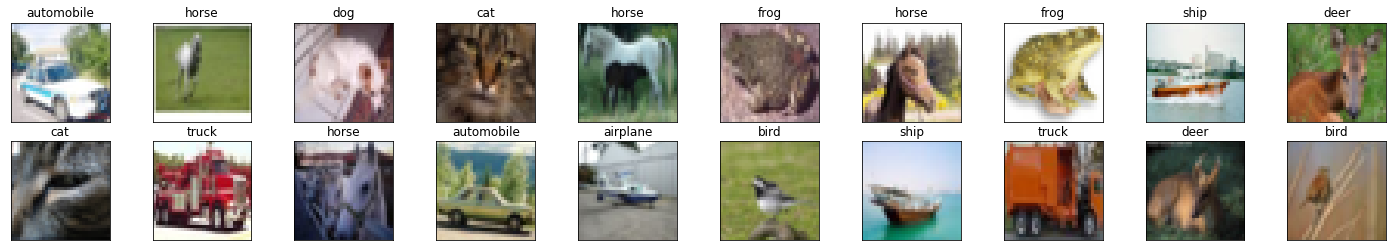

In [4]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Define the Network Architecture

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # FC layers
        self.fc_1 = nn.Linear(64*4*4, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, 10)
        # Dropout layer
        self.dropout = nn.Dropout(p = 0.25)

    def forward(self, x):
        # Add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Convert 3-dimensional vector to 1D vector
        x = x.view(-1, 64*4*4)
        # Add sequence of fully connected layers
        x = self.dropout(x)
        x = F.relu(self.fc_1(x))
        x = self.dropout(x)
        x = F.relu(self.fc_2(x))
        x = self.dropout(x)
        x = self.fc_3(x)
        return x

# Create a complete CNN
model = Net()
print(model)

# Move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=1024, out_features=512, bias=True)
  (fc_2): Linear(in_features=512, out_features=256, bias=True)
  (fc_3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


### Specify loss function and optimizer

In [8]:
import torch.optim as optim

# Specify loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01)

### Train the Network

In [9]:
# Number of epochs to train the model
n_epochs = 25

valid_loss_min = np.Inf # Track change in validation loss

for epoch in range(1, n_epochs+1):

    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # Train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: Compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: Compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # Validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: Compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # Calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # Print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.839291 	Validation Loss: 0.456241
Validation loss decreased (inf --> 0.456241).  Saving model ...
Epoch: 2 	Training Loss: 1.673925 	Validation Loss: 0.378788
Validation loss decreased (0.456241 --> 0.378788).  Saving model ...
Epoch: 3 	Training Loss: 1.429338 	Validation Loss: 0.326211
Validation loss decreased (0.378788 --> 0.326211).  Saving model ...
Epoch: 4 	Training Loss: 1.275353 	Validation Loss: 0.296440
Validation loss decreased (0.326211 --> 0.296440).  Saving model ...
Epoch: 5 	Training Loss: 1.183171 	Validation Loss: 0.282403
Validation loss decreased (0.296440 --> 0.282403).  Saving model ...
Epoch: 6 	Training Loss: 1.102546 	Validation Loss: 0.257094
Validation loss decreased (0.282403 --> 0.257094).  Saving model ...
Epoch: 7 	Training Loss: 1.041555 	Validation Loss: 0.243452
Validation loss decreased (0.257094 --> 0.243452).  Saving model ...
Epoch: 8 	Training Loss: 0.976599 	Validation Loss: 0.226188
Validation loss decreased (0.24345

KeyboardInterrupt: 

### Load the Model with Lowest Validation Loss

In [ ]:
model.load_state_dict(torch.load('model_cifar.pt'))

### Test the Trained Model

In [ ]:
# Track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# Iterate over test data
for data, target in test_loader:
    # Move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # Forward pass: Compute predicted outputs by passing inputs to the model
    output = model(data)
    # Calculate the batch loss
    loss = criterion(output, target)
    # Update test loss 
    test_loss += loss.item()*data.size(0)
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # Compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # Calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

### Visualize Sample Test Results 

In [ ]:
# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# Move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# Get sample outputs
output = model(images)
# Convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))